In [12]:
# load package
# string 
import re

# date
from datetime import datetime

# math
import pandas as pd
import numpy as np
import scipy as sp
import random

# nlp
from pattern.de import parse, conjugate, singularize, pluralize

# sys
import sys
import os
import time
import warnings

# machine learning
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, gaussian_process, discriminant_analysis
from xgboost import XGBClassifier

# model utils
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection 
from sklearn import model_selection
from sklearn import metrics

# plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix #??
# = show plots in Jupyter Notebook browser
%matplotlib inline 
mpl.style.use('ggplot') #??
sns.set_style('white')
pylab.rcParams['figure.figsize'] = 12,8 #??

# show all columns
from IPython.display import display
pd.options.display.max_columns = None

# self define
sys.path.append('../../utils/')

In [3]:
# read files
lb_wsp_2014 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2014.csv', sep = ';')
lb_wsp_2015 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2015.csv', sep = ';')
lb_wsp_2016 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2016.csv', sep = ';')
lb_wsp_2017 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2017.csv', sep = ';')
lb_wsp_2018 = pd.read_csv('../data/Autohaus_weeber/leonberg_werkstattposten_2018.csv', sep = ';')
std_wsp_2014 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2014.csv', sep = ';')
std_wsp_2015 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2015.csv', sep = ';')
std_wsp_2016 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2016.csv', sep = ';')
std_wsp_2017 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2017.csv', sep = ';')
std_wsp_2018 = pd.read_csv('../data/Autohaus_weeber/weil_der_stadt_werkstattposten_2018.csv', sep = ';')
# cat
d1 = lb_wsp_2014.copy()
d2 = lb_wsp_2015.copy()
d3 = lb_wsp_2016.copy()
d4 = lb_wsp_2017.copy()
d5 = lb_wsp_2018.copy()

d6 = std_wsp_2014.copy()
d7 = std_wsp_2015.copy()
d8 = std_wsp_2016.copy()
d9 = std_wsp_2017.copy()
d10 = std_wsp_2018.copy()

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (1,15) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [8]:
# for training we use data from 14 - 17 in lb_wsp
train1 = pd.concat([d1,d2,d3,d4,d5], 0)
train2 = pd.concat([d6,d7,d8,d9,d10], 0)
train1['Autohaus'] = 'leonberg'
train2['Autohaus'] = 'weil'
train = pd.concat([train1, train2], 0)

In [4]:
# 转化为auftrag table， 但是这次合并的是Teile-Nr项
# 给的数据的每一行都是一个维修项，初衷是，把属于同一个auftrag的维修项合并到一起，看一下，在同一个Auftrag中，经常一起修的是那些内容

def toAuftragTable(df, att, auftn, clean = True):
    """
    input:
        df, DataFrame:
            the dataframe
        att, string:
            the column name of the target attribute
        auftn, string:
            the column name of the aftragsnummer attribute
        clean:
            when true, drop the null item in auftn attribute.
    output:
        df_g, DataFrame:
            dataframe contrains two columns auftn and att
            type of item in att is string, separate with ';'
    """
    # assert: make sure the type of the attributes inputted
    
    # extract the att and date columns
    df = df[[att, auftn]]
    # set type to object
    #df[att] = df[att].astype('object')
    #df[auftn] = df[auftn].astype('object')
    # if clean is True, drop the fake data, like the null data
    if clean:
        print("Falls Null date exist, drop these dates directly")
        #df = df.drop(df[df[att].isnull()].index)
        df = df.drop(df[df[auftn].isnull()].index)
    # group and sum 
    df_g = df.groupby([auftn], as_index = False).apply(agg)
    return df_g

# apply 只能对单行进行处理，而不是对整个分组进行处理，所以估计应该把axis换成1，比较好
def agg(x):
    # 是否用‘ ’分隔会比较好，这样就不用对初始的属性，
    # x 在这里是dataframe？？？
    #x = [str(i) for i in x]
    x = x.apply(lambda x: ';'.join(set([str(i) for i in x])), axis = 0)
    #x = x.apply(lambda x: ' '.join(set(x)), axis = 0)
    #print(x.columns.values)
    return x

In [42]:
class FreDict:
    """
    统计单词和出现的频率
    文档中的每个字都会被记录进去，所以应该确认输入的文件内容，只含有目标列属性
    """
    def __init__(self, path, header = True, sep = ';', clean = False, recover = False, singular = False):
        """
        input:
            path: string
                the path of the file
            header: boolean
                weather the file contains header of not
            sep: string
                the sep of the file in each line
            clean: boolean
                remove the word with single buchstachben or not
            recover: boolean
                transform 'ae', 'oe', 'ue', 'ss' back to 'ä', 'ö', 'ü', 'ß' usw.
            singular: boolean
                weather turns the word to singular or not
        """
        self.dict_re = {'ae': 'ä', 'oe': 'ö', 'ue': 'ü', 'ß': 'ss', 'u.': 'und ', 'fzg': 'fahrzeug', ' f ': ' für '}
        self.words, self.dict_count = self._load_data(path, header, sep, clean, recover, singular) # list of Words
        self.ls_sorted = self._sort_dict(self.words) # list of list
        self.len = len(self.words)
    
    def get_word(self, w):
        if w in self.dict_count.keys():
            return self.dict_count[w]
        else:
            return Word('x', 0, 'NAW')
    
    def get_best(self, s):
        """
        input:
            s string:
                list of words in form of string
        output:
            out string:
                the frequentest word
        """
        words = s.split(' ')
        words = [word.strip() for word in words]
        out = 'xxx'
        count = 0
        for word in words:
            tmp = self.get_word(word)
            if tmp.get_count() > count:
                out = tmp.get_word()
                count = tmp.get_count()
        return out
        
    def top(self, n = 10):
        # return list of list
        # get the top n item 
        if n == -1:
            return self.ls_sorted
        return self.ls_sorted[:n]
    
    def top_norm(self, n = 10):
        # get the top n norm
        out = []
        counter = 0
        for i in self.ls_sorted:
            if counter >= n and n != -1:
                break
            if i[2] == 'NN' or i[2] == 'NNP' or i[2] == 'NNS' or i[2] == 'NNPS':
                out.append(i)
            counter += 1
        return out
    
    def top_verb(self, n = 10):
        # get the top n verb
        out = []
        counter = 0
        for i in self.ls_sorted:
            if counter >= n and n != -1:
                break
            if i[2] == 'VB' or i[2] == 'VBZ' or i[2] == 'VBP' or i[2] == 'VBD' or i[2] == 'VBN' or i[2] == 'VBG':
                out.append(i)
            counter += 1
        return out
    
    def _load_data(self, path, header, sep, clean, recover, singular):
        """
        return list of words and count dictionary
        """
        dic = {}
        with open(path) as fi:
            counter = 0
            for li in fi:
                # 假设句子两侧存在双引号
                li = li.strip()
                if li[0] == '"':
                    li = li[1:]
                if li[-1] == '"':
                    li = li[:-1]
                if header and counter == 0:
                    # drop first line if header is true
                    counter += 1
                    continue
                li = li.strip()
                if recover:
                    # recover same express if necessary
                    for i, j in self.dict_re.items():
                        if i in li:
                            li = re.sub(i, j, li)
                #items = re.split('[;, ]', li)
                items = re.split(';', li)
                #items = li.split(sep)
                for item in items:
                    item = item.strip()
                    if item not in dic.keys():
                        if clean and len(item) <= 1:
                            # remove the item with less than 2 ziffer
                            continue
                        else:
                            dic[item] = 1
                    else:
                        dic[item] += 1
                counter += 1
        # transform to Word
        words = []
        for i, j in dic.items():
            try:
                if singular:
                    i = singularize(i).lower()
                words.append(Word(i, j, parse(i).split('/')[1]))
                #words.append(Word(i, j, parse(conjugate(i)).split('/')[1]))
            except:
                words.append(Word(i, j, ''))
        # pack the dic
        dic = {i: Word(i, j, parse(i).split('/')[1]) for i, j in dic.items() if len(i) > 0 }
        # return 
        return words, dic
    
    def _sort_dict(self, words):
        # return list of words, sorted according to the count
        li_sorted = sorted(words, key = lambda x: x.get_count(), reverse = True) 
        # transform to list
        out = []
        for i in li_sorted:
            out.append(i.to_list())
        return out
    
class Word:
    """
    use @property to rewrite the class
    """
    def __init__(self, word = 'NN', count = 1, tag = 'NN'):
        self.word = word
        self.count = count
        self.tag = tag

    def to_list(self):
        out = [self.word, self.count, self.tag]
        return out
    
    def __str__(self):
        return self.word + " " + self.count + " " + self.tag

    def get_count(self):
        return self.count

    def get_tag(self):
        return self.tag

    def get_word(self):
        return self.word

    def set_count(self, c):
        self.count = c

    def set_tag(self, t):
        self.tag = t

    def set_word(self, w):
        self.word = w

In [7]:
df_ta = toAuftragTable(train, 'Teile-Nr', 'Auftragsnummer')

Falls Null date exist, drop these dates directly


In [9]:
# merget the data original dataframe to df
df_sel = train[['Auftragsnummer', 'KM-Stand', 'Auftragsdatum', 'Markencode', 'Lagerortcode', 'Adressanredecode', 'Fahrgestellnummer', 'Motorcode', 'Modell', 'Getriebecode']]
df_sel = df_sel.drop_duplicates()
df_ta = pd.merge(df_ta, df_sel, how = 'left', on = 'Auftragsnummer')

In [16]:
# 比较verhalten，最粗浅的方法就是，看一下，各个类型的客户，主要都修了什么东西所以就分组吧
# 这里以Adressanrede为例子，进行观测
tmp = df_ta.copy()
tmp['count'] = 1
motor = tmp[['Adressanredecode', 'count']]
mc = motor.groupby('Adressanredecode', as_index = False).count()
tmp = pd.merge(df_ta, mc, how = 'left', on = 'Adressanredecode')
tmp.loc[tmp['count'] < 400, 'Adressanredecode'] = 'others'
tmp.drop('count', axis= 1, inplace= True)
df_ta = tmp

In [19]:
df_ta['Adressanredecode'].unique()

array([nan, 'others', 'Firma', 'Herr', 'Frau'], dtype=object)

In [43]:
# 看一下，Teile-Nr各个项目出现的频率
df_ta.loc[df_ta['Adressanredecode'] == 'others', 'Teile-Nr'].to_csv('/tmp/tmp.csv', sep = ';', index = False)
dic = FreDict('/tmp/tmp.csv', header = True, sep = ';', clean = True, recover = True, singular = False)
dic.top(100)

[['nan', 562, 'NN'],
 ['N  90813202', 83, 'NN'],
 ['G  052164DS', 56, 'NN'],
 ['B  000DS', 49, 'NN'],
 ['W-LRA', 41, 'NNP'],
 ['03L115562', 37, 'NN'],
 ['W-ZUL-GW', 36, 'NNP'],
 ['OEL02', 35, 'NN'],
 ['SKN  90813202', 34, 'NN'],
 ['SKBV18', 29, 'NN'],
 ['N  10648301', 28, 'NN'],
 ['000010006', 28, 'CD'],
 ['WHT000729A', 27, 'NNP'],
 ['G  013DS', 23, 'NN'],
 ['1K1819653B', 23, 'NN'],
 ['N  0138157', 21, 'NN'],
 ['SK03L115562', 21, 'NN'],
 ['1100', 20, 'CD'],
 ['SK1K1819653B', 19, 'NN'],
 ['W-AG-EM', 18, 'NN'],
 ['LMW030000Z0', 16, 'NN'],
 ['1K0825951', 15, 'NN'],
 ['W-SONST', 14, 'NNP'],
 ['E2000', 14, 'NN'],
 ['D  00950025', 13, 'NN'],
 ['059198405', 13, 'CD'],
 ['N  0177535', 13, 'NN'],
 ['N  10320102', 13, 'NN'],
 ['ZVWLWASSER', 12, 'NN'],
 ['4H0819439', 12, 'NN'],
 ['4G1998002A', 12, 'NNP'],
 ['4G9955425', 12, 'NN'],
 ['1K0129620D', 11, 'NN'],
 ['SKG  052164M2', 11, 'JJ'],
 ['839601361', 11, 'CD'],
 ['GEWI', 11, 'NNP'],
 ['071115562C', 11, 'NN'],
 ['NW-PROV-RG', 11, 'NN'],
 ['H-S', 

In [34]:
# 看一下，Teile-Nr各个项目出现的频率
df_ta.loc[df_ta['Adressanredecode'] == 'Firma', 'Teile-Nr'].to_csv('/tmp/tmp.csv', sep = ';', index = False)
dic = FreDict('/tmp/tmp.csv', header = True, sep = ';', clean = True, recover = True, singular = False)
dic.top(100)

[['nan', 28339, 'NN'],
 ['N  90813202', 5206, 'NN'],
 ['an', 3994, 'IN'],
 ['OEL02', 3018, 'NN'],
 ['G  052164DS', 2912, 'NN'],
 ['WHT000729A', 2535, 'NNP'],
 ['03L115562"', 2338, 'NN'],
 ['N  10648301', 2230, 'NN'],
 ['W-AG-EM', 2015, 'NN'],
 ['B  000DS', 1823, 'NN'],
 ['nan"', 1459, 'NN'],
 ['03N115562"', 1427, 'NN'],
 ['000010006"', 1409, 'CD'],
 ['SKN  90813202', 1300, 'NN'],
 ['SKBV18', 1214, 'NN'],
 ['1K1819653B', 1188, 'NN'],
 ['N  91147601', 950, 'NN'],
 ['G  052910DS', 863, 'NN'],
 ['W-LRA"', 860, 'NNP'],
 ['311601361', 849, 'CD'],
 ['000010006', 847, 'CD'],
 ['N  91041702', 840, 'NN'],
 ['N  0138157"', 829, 'NN'],
 ['D  00940104', 811, 'NN'],
 ['4B0422379', 786, 'NN'],
 ['059198405', 761, 'CD'],
 ['8K1998002A', 738, 'NNP'],
 ['1100', 735, 'CD'],
 ['N  90986501', 721, 'NN'],
 ['G  013DS', 713, 'NN'],
 ['W-SONST', 713, 'NNP'],
 ['839601361', 705, 'CD'],
 ['AULGEWI', 659, 'NNP'],
 ['8T0127401A', 653, 'NNP'],
 ['7000"', 644, 'CD'],
 ['4H0819439', 627, 'NN'],
 ['7000', 627, 'CD'],

In [35]:
# 看一下，Teile-Nr各个项目出现的频率
df_ta.loc[df_ta['Adressanredecode'] == 'Herr', 'Teile-Nr'].to_csv('/tmp/tmp.csv', sep = ';', index = False)
dic = FreDict('/tmp/tmp.csv', header = True, sep = ';', clean = True, recover = True, singular = False)
dic.top(100)

[['nan', 23643, 'NN'],
 ['an', 3999, 'IN'],
 ['N  90813202', 3967, 'NN'],
 ['B  000DS', 2977, 'NN'],
 ['OEL02', 2300, 'NN'],
 ['G  052164DS', 2094, 'NN'],
 ['1K1819653B', 1899, 'NN'],
 ['nan"', 1621, 'NN'],
 ['WHT000729A', 1426, 'NNP'],
 ['SKBV18', 1118, 'NN'],
 ['03L115562"', 1091, 'NN'],
 ['SKN  90813202', 1062, 'NN'],
 ['N  10648301', 985, 'NN'],
 ['000010006"', 874, 'CD'],
 ['000010006', 770, 'CD'],
 ['N  0138157"', 757, 'NN'],
 ['1K0825951', 756, 'NN'],
 ['G  013DS', 692, 'NN'],
 ['1100', 689, 'CD'],
 ['ZVWLWASSER', 672, 'NN'],
 ['071115562C', 614, 'NN'],
 ['W-AG-EM', 607, 'NN'],
 ['N  0138157', 578, 'NN'],
 ['839601361', 565, 'CD'],
 ['E2000"', 565, 'NN'],
 ['2000"', 559, 'CD'],
 ['B  000DS"', 528, 'NN'],
 ['04E115561H', 520, 'NNP'],
 ['G  052164DS"', 512, 'NN'],
 ['SK1K1819653B', 484, 'NN'],
 ['5Q0819653', 484, 'NN'],
 ['N  10332002', 482, 'NN'],
 ['H-S', 482, 'NNP'],
 ['LMW030000Z0', 471, 'NN'],
 ['311601361', 443, 'CD'],
 ['ZZ KLE', 432, 'NNP'],
 ['03C115561H', 425, 'NNP'],
 [

In [36]:
# 看一下，Teile-Nr各个项目出现的频率
df_ta.loc[df_ta['Adressanredecode'] == 'Frau', 'Teile-Nr'].to_csv('/tmp/tmp.csv', sep = ';', index = False)
dic = FreDict('/tmp/tmp.csv', header = True, sep = ';', clean = True, recover = True, singular = False)
dic.top(100)

[['nan', 12185, 'NN'],
 ['N  90813202', 2012, 'NN'],
 ['an', 1803, 'IN'],
 ['B  000DS', 1641, 'NN'],
 ['G  052164DS', 1376, 'NN'],
 ['OEL02', 1024, 'NN'],
 ['1K1819653B', 959, 'NN'],
 ['nan"', 845, 'NN'],
 ['SKN  90813202', 542, 'NN'],
 ['SKBV18', 528, 'NN'],
 ['1100', 524, 'CD'],
 ['WHT000729A', 508, 'NNP'],
 ['N  10648301', 459, 'NN'],
 ['G  052164DS"', 427, 'NN'],
 ['000010006"', 411, 'CD'],
 ['04E115561H', 405, 'NNP'],
 ['03L115562"', 396, 'NN'],
 ['N  0138157', 366, 'NN'],
 ['839601361', 360, 'CD'],
 ['1K0825951', 354, 'NN'],
 ['000010006', 338, 'CD'],
 ['E2000"', 330, 'NN'],
 ['ZVWLWASSER', 327, 'NN'],
 ['1000"', 327, 'CD'],
 ['2000"', 325, 'CD'],
 ['N  90288901"', 320, 'NN'],
 ['1000', 318, 'CD'],
 ['G  013DS', 313, 'NN'],
 ['W-AG-EM', 312, 'NN'],
 ['03C115561H', 308, 'NNP'],
 ['LMW030000Z0', 297, 'NN'],
 ['N  0138157"', 290, 'NN'],
 ['B  000DS"', 286, 'NN'],
 ['GEWI', 285, 'NNP'],
 ['03C115561H"', 268, 'NNP'],
 ['ZZ KLE', 264, 'NNP'],
 ['BV17', 245, 'NN'],
 ['5Q0819653', 243, '

In [37]:
# 看一下，Teile-Nr各个项目出现的频率
df_ta.loc[df_ta['Adressanredecode'].isna(), 'Teile-Nr'].to_csv('/tmp/tmp.csv', sep = ';', index = False)
dic = FreDict('/tmp/tmp.csv', header = True, sep = ';', clean = True, recover = True, singular = False)
dic.top(10)

[['nan', 816, 'NN'],
 ['an', 225, 'IN'],
 ['N  90813202', 81, 'NN'],
 ['G  052164DS', 49, 'NN'],
 ['nan"', 46, 'NN'],
 ['WHT000729A', 38, 'NNP'],
 ['B  000DS', 35, 'NN'],
 ['1K1819653B', 26, 'NN'],
 ['03L115562"', 23, 'NN'],
 ['LMW030000Z0', 21, 'NN']]

### Tese

In [70]:
tmp = df_ta.loc[df_ta['Fahrgestellnummer'] == 'TMBJJ7NE6D0034366', ['Fahrgestellnummer', 'Auftragsdatum', 'KM-Stand']]

In [72]:
tmp['Auftragsdatum'] = pd.to_datetime(tmp['Auftragsdatum'], dayfirst= True)

In [73]:
tmp = tmp.sort_values(by = 'Auftragsdatum')

In [74]:
tg = tmp[['Auftragsdatum', 'KM-Stand']]

In [75]:
tg['KM-Stand'] = tg['KM-Stand'].map(lambda x: re.sub(',', '.', x)).astype(float)

/Users/ihuangyiran/anaconda2/envs/data_mining/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


(735274.0, 736170.0)

<Figure size 432x288 with 0 Axes>

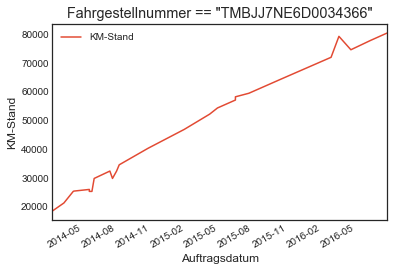

In [87]:
fig = plt.figure()
#ts = plt.plot(tg['Auftragsdatum'], tg['KM-Stand'])
ts = tg.plot(x = 'Auftragsdatum', y = 'KM-Stand')
#fig.suptitle('Fahrgestellnummer == "TMBJJ7NE6D0034366"')
ts.set_title('Fahrgestellnummer == "TMBJJ7NE6D0034366"')
plt.xlabel('Auftragsdatum')
plt.ylabel('KM-Stand')
ts.set_xlim(tg['Auftragsdatum'].iloc[0], tg['Auftragsdatum'].iloc[-1])

In [77]:
tmp

,Fahrgestellnummer,Auftragsdatum,KM-Stand
2054,TMBJJ7NE6D0034366,2014-02-10,"18520,00"
3802,TMBJJ7NE6D0034366,2014-03-13,"21332,00"
5418,TMBJJ7NE6D0034366,2014-04-07,"25358,00"
5709,TMBJJ7NE6D0034366,2014-04-09,"25467,00"
8261,TMBJJ7NE6D0034366,2014-05-20,"26042,00"
8263,TMBJJ7NE6D0034366,2014-05-20,"25358,00"
9034,TMBJJ7NE6D0034366,2014-05-27,"25358,00"
9212,TMBJJ7NE6D0034366,2014-06-02,"29865,00"
11565,TMBJJ7NE6D0034366,2014-07-14,"32431,00"
11567,TMBJJ7NE6D0034366,2014-07-21,"29865,00"


In [85]:
tg['Auftragsdatum'].iloc[0]

Timestamp('2014-02-10 00:00:00')

In [9]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3350115 entries, 0 to 291459
Data columns (total 22 columns):
Auftragsnummer          object
AW-Nr                   object
Teile-Nr                object
KM-Stand                object
Beschreibung            object
Auftragsdatum           object
Markencode              object
Lagerortcode            object
Adressanredecode        object
Fahrgestellnummer       object
Motorcode               object
Fahrzeugmodellnummer    object
Modell                  object
Typ                     object
Getriebecode            object
Getriebeartcode         object
Gewicht                 object
Leistung (KW)           float64
Erstzulassungsdatum     object
Neuwagen                object
Unnamed: 20             float64
Autohaus                object
dtypes: float64(2), object(20)
memory usage: 587.9+ MB


In [30]:
train[train['Markencode'] == '27.04.2006']

,Auftragsnummer,AW-Nr,Teile-Nr,KM-Stand,Beschreibung,Auftragsdatum,Markencode,Lagerortcode,Adressanredecode,Fahrgestellnummer,Motorcode,Fahrzeugmodellnummer,Modell,Typ,Getriebecode,Getriebeartcode,Gewicht,Leistung (KW),Erstzulassungsdatum,Neuwagen,Unnamed: 20,Autohaus
14067,103K,NaN,HDV,NaN,"0,00",0,27.04.2006,als Neuwagen bezogen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,leonberg
14069,103K,NaN,HDV,NaN,"0,00",0,27.04.2006,als Neuwagen bezogen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,leonberg
14071,103K,NaN,HDV,NaN,"0,00",0,27.04.2006,als Neuwagen bezogen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,leonberg
23457,103K,NaN,HDV,NaN,"0,00",0,27.04.2006,als Neuwagen bezogen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,leonberg
23459,103K,NaN,HDV,NaN,"0,00",0,27.04.2006,als Neuwagen bezogen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,leonberg
23461,103K,NaN,HDV,NaN,"0,00",0,27.04.2006,als Neuwagen bezogen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,leonberg
23463,103K,NaN,HDV,NaN,"0,00",0,27.04.2006,als Neuwagen bezogen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,leonberg
23465,103K,NaN,HDV,NaN,"0,00",0,27.04.2006,als Neuwagen bezogen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,leonberg
23467,103K,NaN,HDV,NaN,"0,00",0,27.04.2006,als Neuwagen bezogen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,leonberg
23469,103K,NaN,HDV,NaN,"0,00",0,27.04.2006,als Neuwagen bezogen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,leonberg


In [31]:
fake = train['Markencode'].map(lambda x: bool(re.search('\d', str(x))))

In [34]:
train[fake]

,Auftragsnummer,AW-Nr,Teile-Nr,KM-Stand,Beschreibung,Auftragsdatum,Markencode,Lagerortcode,Adressanredecode,Fahrgestellnummer,Motorcode,Fahrzeugmodellnummer,Modell,Typ,Getriebecode,Getriebeartcode,Gewicht,Leistung (KW),Erstzulassungsdatum,Neuwagen,Unnamed: 20,Autohaus
14067,103K,NaN,HDV,NaN,"0,00",0,27.04.2006,als Neuwagen bezogen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,leonberg
14069,103K,NaN,HDV,NaN,"0,00",0,27.04.2006,als Neuwagen bezogen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,leonberg
14071,103K,NaN,HDV,NaN,"0,00",0,27.04.2006,als Neuwagen bezogen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,leonberg
23457,103K,NaN,HDV,NaN,"0,00",0,27.04.2006,als Neuwagen bezogen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,leonberg
23459,103K,NaN,HDV,NaN,"0,00",0,27.04.2006,als Neuwagen bezogen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,leonberg
23461,103K,NaN,HDV,NaN,"0,00",0,27.04.2006,als Neuwagen bezogen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,leonberg
23463,103K,NaN,HDV,NaN,"0,00",0,27.04.2006,als Neuwagen bezogen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,leonberg
23465,103K,NaN,HDV,NaN,"0,00",0,27.04.2006,als Neuwagen bezogen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,leonberg
23467,103K,NaN,HDV,NaN,"0,00",0,27.04.2006,als Neuwagen bezogen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,leonberg
23469,103K,NaN,HDV,NaN,"0,00",0,27.04.2006,als Neuwagen bezogen,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,leonberg


In [37]:
train['Adressanredecode'].unique()

array(['Firma', 'Herr', 'Frau', nan, 'AN', 'FA_F', 'FA_M', 'HR.DR.',
       'OHNE', 'AUTOHAUS', 'FR.DR.', 'HERR+FRAU', 'FAHRSCHULE', 'FR.PROF.',
       'HR U. FR', 'PR', 'FRAU+HERR', 'HE', 'FAMILIE', 'HERR UND F',
       'FRAU U HER'], dtype=object)